# Project 1: Data Exploration, Visualization and Dimensionality Reduction
## Animal Shelter Outcomes: A Classification Problem
#### Alex Matsunami, RJ Smith, Cory Nichols

## Business Understanding


Millions of animal companions end up in shelters each year in the United States. These animals may be stray, rescued from a difficult situation or given up by their previous families. Each year, roughly 40 percent of all dogs and cats in shelters are euthanized. 

Our dataset comes from the Austin Animal Center in Austin, Texas and is part of a Kaggle competition. Using this data, we hope to find trends or rule sets identifying the outcomes of animals in shelters. The findings would subsequently drive shelter practices, hopefully for more social good than business good. For instance, if spaying or neutering a dog or cat is highly suggestive of a favorable outcome for an animal, shelters should implement policies ensuring all animals are fixed prior to adoption. This practice may cost the shelter more money, but would improve the welfare of the animal population. Further, could something as simple as giving each an animal a name drive a more favorable outcome? This particular practice would cost nothing but time and in turn improve the welfare of the animal population in cities. Cost savings, however, could be gained from our analysis. For instance, it may be easy enough to automate intake and processes for certain breeds or genders of animals while focusing attention on breeds or genders of animals that the data indicate "need more help."

We intend to use the 27 thousand records in the training set as a reference for other major cities in the United States, where most animal shelter practices are similar from an intake and outcome perspective. Our dataset includes statistics on breed, color, sex, and age from the Austin Animal Center.

Success should be categorized into analytical and business goals. Analytical goals would be based on classification accuracy on a sizeable test data set given by a confusin matrix where overall classification accuracy is greater than 85% at minimum with at least 85% precision. Further, and possibly more importantly, we hope our analysis drives at least a 20% decrease in animal euthanizations over a two calendar year period.  


## Data Meaning and Data Types  (Add Info Here)

### Data Set Location

The data set is available on Kaggle: https://www.kaggle.com/c/shelter-animal-outcomes/data 


## Data Preprocessing: Transformation and Statistics 

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler,Imputer
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')


Our dataset is made up of 10 variables, many of which can be split or transformed into additional variables. Further, the majority of the variables are categorical, mostly nominal variables except for ordinal variables like Age and temporal variables like DateTime. Some variables, such as AnimalID, will provide no value in our analysis. AnimalID in particular can be dropped from the dataset. 

Our class variable is OutcomeType. We are interested in classifying animal outcome types given the other explanatory variables, which we will elaborate upon further.


In [3]:
df.head(3)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [4]:
print 'Data types and counts:\n\n', df.info(), '\n\n'
print 'Data Descriptions: Counts, Frequency'

df.describe()

Data types and counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB
None 


Data Descriptions: Counts, Frequency


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824



Based upon the information retrieved from the DataFrame, we are dealing with roughly 27 thousand records in the training set. We are only interested in the "OutcomeType" as our y (classifier) data. Outcome subtype is a sparse drill down on the Outcome type with sub-codes which are not explained thoroughly. Therefore, we recommend dropping this value as it is aub-variable of the outcome variable we are interested with roughly 50% valid values.

The good news is: 40% of animals are being adopted, most of which are neutered male dogs about a year old. 

In regard to new feature creation, we observe multiple opportunities. For instance, it will be interesting to see if having a name affects outcome and if the type of breed is aggressive (has a "reputation"). We can also see converting the AgeuponOutcome being valuable. 

However, before we create or transform features, let's clean up the data a bit more. There are a few nulls in our dataset. Of concern are the nulls in AgeuponOutcome and SexuponOutcome. Because we care about whether or not a pet is named, the nulls in Name are not a concern. Further, OutcomeSubtype is simply a click down of OutcomeType, which is our classifier, and is quite sparse. Because we are dropping this column, we are not concerned with the nulls.


#### Data Cleanup

In [5]:
print 'Number of nulls in the data set: \n', df.isnull().sum()

Number of nulls in the data set: 
AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64


In [6]:
del df['OutcomeSubtype'], df['AnimalID'] # drop extraneous data  columns
df = df.dropna(subset=['SexuponOutcome']) # drop the one nan row in the sex column. Not a large impact to analysis.
df = df.reset_index()

print 'Number of unique, non nan ages:', len(np.unique(df.AgeuponOutcome[~pd.isnull(df['AgeuponOutcome'])])) 


Number of unique, non nan ages: 44



categorical filling strategy:
fill the nulls with top 3 categories in a column vector randomly for age and sex
there is a string for age "0 years" with 22 instances. This provides about "0" value. We will also fill unknowns
in the sex column vector with the same logic. We will fill these columns by iterating over and randomly choosing 
between the top 3 values instead of assigning an arbitrary value. We believe this is relevant because the top 3
categories are spread relatively similarly, with roughly similar percents of total.


In [7]:
from collections import Counter
from random import randint

randChooser = []
for i in ['AgeuponOutcome', 'SexuponOutcome']:
    randChooser.append(Counter(df[i].values).most_common(3)) # get the 3 most common categories

df['AgeuponOutcome'] = [randChooser[0][randint(0,2)][0] # randomly pick one of the three categories and replace null
                        if pd.isnull(i) or i.lower() == '0 years' else i for i in df['AgeuponOutcome'].values]
 
df['SexuponOutcome'] = [randChooser[1][randint(0,2)][0]\
                        if i.lower() == 'unknown' else i for i in df['SexuponOutcome'].values]

In [8]:
df.head()

,index,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Data Creation and Transformation


All columns outside of the name column are now non-null.

Let's create some useful variables in our data set. It would be interesting to investigate whether or not a potential adoptee having a name has an effect on their outcome.

The gender and what we will call "intactness" (whether an animal is spayed or neutered) are also interesting variables to investigate.

Further, it would be better to represent age as a continuous ratio variable. We will transform age into days.


In [9]:
print 'There are %d unique names in the data set' % len(np.unique(df['Name'].values))

# 6375 unique names. That is quite a few names. Let's generalize into a binary feature called has_name instead:
df['has_name'] = [0 if pd.isnull(i) else 1 for i in df['Name']]

# Further, let's split out the intactness of an animal: whether or not the animal has been spayed or neutered
# as well as the gender:
df['intact'] = [i.split()[0] for i in df['SexuponOutcome']]
df['gender'] = [i.split()[1] for i in df['SexuponOutcome']]

# we will also convert ageuponoutcome into days:
ageMap = {'year': 365, 
          'week': 7, 
          'month': 30,
          'day': 1} 

df['AgeuponOutcome'] = [i.rstrip('s').split() for i in df['AgeuponOutcome'].values] # clean text to keep mapping simple

ageList = []
for i in df['AgeuponOutcome'].values:
    for k,v in ageMap.items():
        if i[1] == k:
            ageList.append(int(i[0]) * v)
df['AgeuponOutcome'] = ageList
df.info()

There are 6375 unique names in the data set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26728 entries, 0 to 26727
Data columns (total 12 columns):
index             26728 non-null int64
Name              19037 non-null object
DateTime          26728 non-null object
OutcomeType       26728 non-null object
AnimalType        26728 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26728 non-null int64
Breed             26728 non-null object
Color             26728 non-null object
has_name          26728 non-null int64
intact            26728 non-null object
gender            26728 non-null object
dtypes: int64(3), object(9)
memory usage: 2.4+ MB


C:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26728 entries, 0 to 26727
Data columns (total 12 columns):
index             26728 non-null int64
Name              19037 non-null object
DateTime          26728 non-null object
OutcomeType       26728 non-null object
AnimalType        26728 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26728 non-null int64
Breed             26728 non-null object
Color             26728 non-null object
has_name          26728 non-null int64
intact            26728 non-null object
gender            26728 non-null object
dtypes: int64(3), object(9)
memory usage: 2.4+ MB


In [11]:
# lets also identify potentially 'aggressive' breeds using a bit of regex and top 10 aggressive breeds list: 
# http://www.therichest.com/rich-list/the-biggest/the-worlds-10-most-dangerous-dog-breeds/?view=all

import re

agg_breeds = ['Bull','Doberman','Rottweiler','Husky','German','Boxer','Malamute','Dane']
df['Breed_orig'] = df['Breed']
df['Breed'] = [re.split('\W+',i) for i in df['Breed']]

aggColumn = []
for i in df['Breed'].values:
    if len(agg_breeds) != len(set(agg_breeds).difference(i)):
        aggColumn.append((1))
    else:
        aggColumn.append(0)       
df['is_aggressive'] = aggColumn


In [12]:
# let's also grab only the primary color using same regex approach and reduce the number of categories
colorMap = {'exotic':['Agouti','Calico','Lynx','Tricolor','Tortie','Flame','Torbie'],
            'dark':['Black','Chocolate','Liver','Sable','Blue','Seal','Red'],
            'neutral':['Gray','Silver','Tan','Buff','Brown','Fawn'],
            'light':['Cream','Pink','White','Yellow','Lilac','Ruddy','Apricot','Orange','Gold']}

df['primary_color'] = [re.split('\W+',i)[0] for i in df['Color']]

for idx, color in enumerate(df['primary_color'].values):
    for k,v in colorMap.items():
        if color in v:
            df.set_value(idx,'primary_color', k)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26728 entries, 0 to 26727
Data columns (total 15 columns):
index             26728 non-null int64
Name              19037 non-null object
DateTime          26728 non-null object
OutcomeType       26728 non-null object
AnimalType        26728 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26728 non-null int64
Breed             26728 non-null object
Color             26728 non-null object
has_name          26728 non-null int64
intact            26728 non-null object
gender            26728 non-null object
Breed_orig        26728 non-null object
is_aggressive     26728 non-null int64
primary_color     26728 non-null object
dtypes: int64(4), object(11)
memory usage: 3.1+ MB


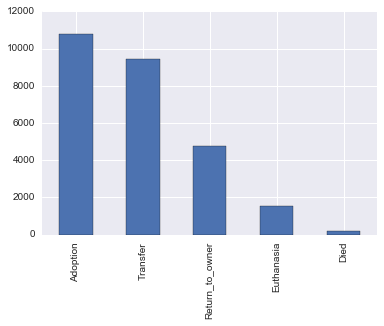

In [14]:
import matplotlib.pyplot as plt
df.OutcomeType.value_counts().plot(kind='bar')


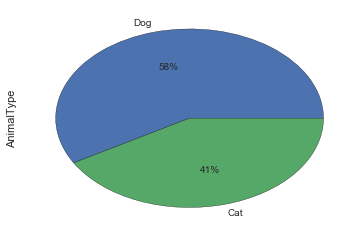

In [15]:
df.AnimalType.value_counts().plot(kind='pie', autopct='%1d%%')

In [16]:
df.head(5)

,index,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,has_name,intact,gender,Breed_orig,is_aggressive,primary_color
0,0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,365,"[Shetland, Sheepdog, Mix]",Brown/White,1,Neutered,Male,Shetland Sheepdog Mix,0,neutral
1,1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,365,"[Domestic, Shorthair, Mix]",Cream Tabby,1,Spayed,Female,Domestic Shorthair Mix,0,light
2,2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,730,"[Pit, Bull, Mix]",Blue/White,1,Neutered,Male,Pit Bull Mix,1,dark
3,3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,21,"[Domestic, Shorthair, Mix]",Blue Cream,0,Intact,Male,Domestic Shorthair Mix,0,dark
4,4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,730,"[Lhasa, Apso, Miniature, Poodle]",Tan,0,Neutered,Male,Lhasa Apso/Miniature Poodle,0,neutral


In [17]:
# Source: http://www.petinsurance.com/healthzone/pet-articles/pet-breeds/Top-10-Dog-Breeds.aspx

TopDogBreeds = ['Boxer', 'Rottweiler', 'Poodle', 'Yorkshire Terrier',
                'French Bulldog', 'Beagle', 'Bulldog',
                'Golden Retriever', 'German Shepherd', 'Labrador Retriever']

DogBreedTop = []
for i in df['Breed_orig']:
    matched = False
    for topBreed in TopDogBreeds:
        if topBreed in i:
            DogBreedTop.append(topBreed)
            matched = True
            break
    if not matched:
        DogBreedTop.append('Other')       

df['DogBreedTop'] = DogBreedTop


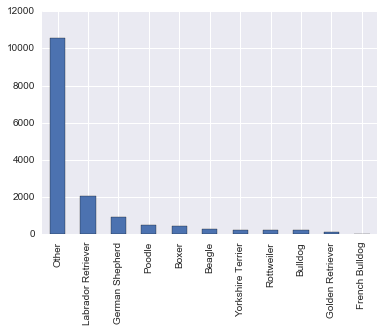

In [18]:
df.loc[df.AnimalType == 'Dog', 'DogBreedTop'].value_counts().plot(kind='bar')